In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [3]:
xs = np.array([[25,26],[25,26]])
ys = np.array([[525,525],[526,526]])

print(xs.shape, ys.shape)   # (15, 34) (15, 34)

print(xs.shape, ys.shape)  # (10, 10) (10, 10)

gatei = np.nanmin(xs)
gateip1 = np.nanmax(xs)
gateip3 = np.nanmax(xs) + 1   # the eastern "gate" index for this range,  we take -advx
gatej = np.nanmin(ys)
gatejp1 = np.nanmin(ys) + 1   # the northern "gate" index we take at j+1 for -advy
gatejp2 = np.nanmax(ys) +1
gatejp2

print(gatei,gateip3)
print(gatej,gatejp2)
x1d = xs.ravel()  # or xs.flatten()
y1d = ys.ravel()

(2, 2) (2, 2)
(2, 2) (2, 2)
25 27
525 527


In [5]:
# try to just get the budget at this individual point with the gates

In [4]:
# --- allocate per-timestep volumes (if you want them) ---
vol = np.zeros((len(tsstr), nz, ny, nx))
for t in range(len(tsstr)):
    # DRF3d should be (nz, ny, nx); DXG/DYG are (ny, nx)
    tmpvol = (np.tile(mygrid['DXG'][None, :, :], (nz, 1, 1))
             * np.tile(mygrid['DYG'][None, :, :], (nz, 1, 1))
             * DRF3d)
    vol[t] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print("doing TS binning")

# --- TS bin definitions (unchanged) ---
n_bins = 112
T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# optional helpers (unchanged)
Tbin,     Sbin     = np.meshgrid(binsTH_edges,   binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)

# --- read THETA/SALT for two timesteps and bin each ---
# choose the two times you want; here: first two entries of tsstr
ts_pair = [int(tsstr[0]), int(tsstr[1])]

file_name = "state_3d_set1"
meta_state = parsemeta(os.path.join(dirState, f"{file_name}.{tsstr[0]}.meta"))
fldlist = np.array(meta_state["fldList"])
want = np.array(["THETA", "SALT"])
recs = np.array([np.where(fldlist == v)[0][0] for v in want])

# storage: float with NaN for out-of-range bins
binned_theta_ts   = np.full((2, nz, ny, nx), np.nan, dtype=float)
binned_salinity_ts= np.full((2, nz, ny, nx), np.nan, dtype=float)

for k, tstamp in enumerate(ts_pair):
    THETA, _, _ = rdmds(os.path.join(dirState, file_name), tstamp, returnmeta=True, rec=int(recs[0]))
    SALT,  _, _ = rdmds(os.path.join(dirState, file_name), tstamp, returnmeta=True, rec=int(recs[1]))

    THETA = THETA.reshape(nz, ny, nx) * np.tile(mymsk[None, :, :], (nz, 1, 1))
    SALT  = SALT.reshape(nz, ny, nx)  * np.tile(mymsk[None, :, :], (nz, 1, 1))

    # bin indices (float with NaN for “outside”)
    bt = bin_array(THETA, binsTH_edges).astype(float)
    bs = bin_array(SALT,  binsSLT_edges).astype(float)

    # handle right-edge assignments and mask
    bt[(bt == nT) | (~np.isfinite(THETA))] = np.nan
    bs[(bs == nS) | (~np.isfinite(SALT ))] = np.nan

    binned_theta_ts[k]    = bt
    binned_salinity_ts[k] = bs

# Now you have:
#   binned_theta_ts[0], binned_salinity_ts[0]  -> at tsstr[0]
#   binned_theta_ts[1], binned_salinity_ts[1]  -> at tsstr[1]
# Shapes: (nz, ny, nx) each; values are bin indices (0..nT-1 / 0..nS-1) or NaN

doing TS binning


# Load some files

In [5]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)
DFxE_SLT = DFxE_SLT.reshape(nz,ny,nx)
DFyE_SLT = DFyE_SLT.reshape(nz,ny,nx)

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [6]:
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

AB_gT = 0
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO = {}
budgO['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
DFxE_TH = DFxE_TH.reshape(nz,ny,nx)
DFyE_TH = DFyE_TH.reshape(nz,ny,nx)
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)


file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

# Run the budget for ONE point

In [7]:
binned_theta = binned_theta_ts[1]
binned_salinity = binned_salinity_ts[1]

In [8]:
# unique coords in order (assumes a rectilinear block)
x_vals = xs[0, :]          # [25, 26, 27]
y_vals = ys[:, 0]          # [525, 526, 527]

# infer spacing (fallback 1 if single cell)
dxs = np.unique(np.diff(x_vals))
dys = np.unique(np.diff(y_vals))
dx = dxs[0] if dxs.size else 1
dy = dys[0] if dys.size else 1

i_min, i_max = x_vals[0], x_vals[-1]
j_min, j_max = y_vals[0], y_vals[-1]

# gates (faces just outside the patch on right/top)
leftx  = np.full_like(y_vals, i_min)
lefty  = y_vals.copy()

rightx = np.full_like(y_vals, i_max + dx)
righty = y_vals.copy()

botx   = x_vals.copy()
boty   = np.full_like(x_vals, j_min)

topx   = x_vals.copy()
topy   = np.full_like(x_vals, j_max + dy)

print(leftx, lefty)
print(botx, boty)
print(rightx, righty)
print(topx, topy)

[25 25] [525 526]
[25 26] [525 525]
[27 27] [525 526]
[25 26] [527 527]


In [9]:
hFacW = mygrid['hFacW']
hFacS = mygrid['hFacS']

In [10]:
# --- Build TS-binned salt "gate" term in Sv/(°C·PSU) ---
# HEREEEEE
# do the reshaping
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
ADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

# Accumulator for gates (same shape as one JtermsS slice)
J_gateS = np.zeros((nS, nT), dtype=float)  # Sv/(°C·PSU)

def add_gate_TS_density(col_SLT, bT_col, bS_col, sign_into_box):
    """
    col_SLT   : (nz,) salt 'substance' transport at the gate column [from ADVx_SLT or ADVy_SLT]
                NOTE: in your workflow you convert to g/s by multiplying with rhoconst.
    bT_col    : (nz,) T-bin indices for that gate column (can be NaN)
    bS_col    : (nz,) S-bin indices for that gate column (can be NaN)
    sign_into_box : +1 if flux is INTO the boxed region, -1 if OUT OF it
    """
    for k in range(len(bT_col)):
        iT = bT_col[k]
        iS = bS_col[k]
        if not np.isfinite(iT) or not np.isfinite(iS): 
            continue
        iT = int(iT); iS = int(iS)
        if not (0 <= iT < nT and 0 <= iS < nS):
            continue

        # Convert to PSU·m^3/s by dividing g/s by rhoconst; then to Sv/(°C·PSU)
        # IMPORTANT: use LOCAL ΔT and ΔS, not a constant.
        val_Sv_per_TS = ( sign_into_box
                          * (col_SLT[k] * myparms['rhoconst'])   # g/s if ADVx_SLT is in PSU·m^3/s; keep this line to mirror your other terms
                          / myparms['rhoconst']                   # -> PSU·m^3/s
                          / (binwidthT[iT] / binwidthS[iS])       # -> m^3/s / (°C)
                          * 1e-6 )                                # -> Sv / (°C)

        J_gateS[iS, iT] += val_Sv_per_TS

# ---- WEST/LEFT boundary (use ADVx_SLT at (j,i); choose sign so INTO box = +)
for j, i in zip(lefty, leftx):
    add_gate_TS_density(ADVx_SLT[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i],
                        sign_into_box=+1)

# ---- SOUTH/BOTTOM boundary (use ADVy_SLT at (j,i))
for j, i in zip(boty, botx):
    add_gate_TS_density(ADVy_SLT[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i],
                        sign_into_box=+1)

# ---- EAST/RIGHT boundary (flip sign relative to WEST)
for j, i in zip(righty, rightx):
    # if your stencil samples interior at i-1 for the right face, keep that here:
    add_gate_TS_density(ADVx_SLT[:, j, i-1], binned_theta[:, j, i-1], binned_salinity[:, j, i-1],
                        sign_into_box=-1)

# ---- NORTH/TOP boundary (flip sign relative to SOUTH)
for j, i in zip(topy, topx):
    add_gate_TS_density(ADVy_SLT[:, j-1, i], binned_theta[:, j-1, i], binned_salinity[:, j-1, i],
                        sign_into_box=-1)

In [11]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow

ETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

# 2) Cellwise volume tendency from free surface (m^3/s)
#    ETAN is sea-surface height; multiplying by cell area RAC gives volume rate per cell.
dVdt_cell = ETAN_dt * RAC                          # m/s * m^2 = m^3/s

# If you're using virtual freshwater (useRFWF==0), there is no real mass/volume flux.
# In that case, you can zero out the real-volume tendency if desired:
if myparms.get('useRFWF', 0) == 0:
    dVdt_cell[...] = 0.0

# (Optional) Apply a spatial mask if you only want a subregion:
# dVdt_cell = dVdt_cell * mymask  # mymask in {0,1} with shape (ny,nx)

# 3) Regional total (Sv)
dVdt_total_Sv = np.nansum(dVdt_cell) * 1e-6        # Sv
print(f"Total dV/dt = {dVdt_total_Sv:.6f} Sv")

# --------------------------------------------------------------------
# OPTIONAL: If you *really* need a 3-D distribution (for plotting),
# you can distribute the surface volume tendency into layers using r*
# weights, but note: the *sum over depth* must equal the surface total.
# This does NOT change the total Sv; it only gives a vertical partition.

tmptend = np.zeros((nz, ny, nx))                   # m^3/s per layer (optional)
if myparms.get('rStar', 0) != 0 and myparms.get('useNLFS', 0) >= 2:
    # Example: vertical weights that sum to 1 where ocean is present
    # (choose weights appropriate for your r* config; here we use thickness fractions)
    DRF3 = mk3D_mod(mygrid['DRF'], np.zeros((nz,ny,nx)))     # broadcast DRF to (nz,ny,nx)
    hC   = mygrid['hFacC']                                   # (nz,ny,nx)
    wet  = np.where(hC > 0, 1.0, 0.0)
    layer_thick = DRF3 * hC                                  # effective layer thickness
    colsum = np.nansum(layer_thick, axis=0)                  # (ny,nx)

    # Avoid divide-by-zero on land
    weights = np.where(colsum[np.newaxis,:,:] > 0, layer_thick / colsum[np.newaxis,:,:], 0.0)

    # Distribute surface volume tendency down the column
    tmptend = weights * dVdt_cell[np.newaxis, :, :]          # still m^3/s per layer
else:
    # If not using r*, keep all volume change at the surface layer (k=0)
    tmptend[0, :, :] = dVdt_cell

bT = np.asarray(binned_theta); bS = np.asarray(binned_salinity)
bwT = np.asarray(binwidthT);  bwS = np.asarray(binwidthS)
Tcent = np.asarray(binsTH_centers); Scent = np.asarray(binsSLT_centers)
xs = np.asarray(xs); ys = np.asarray(ys)

nz, ny, nx = tmptend.shape
nS = bwS.size; nT = bwT.size

# Accumulate per-bin *transport* (Sv) over depths and selected columns
TS_sum_Sv = np.zeros((nS, nT), dtype=float)

for j, i in zip(y1d, x1d):
    if not (0 <= j < ny and 0 <= i < nx):
        continue
    for k in range(nz):
        iT = bT[k, j, i]
        iS = bS[k, j, i]
        if not np.isfinite(iT) or not np.isfinite(iS):
            continue
        iT = int(iT); iS = int(iS)
        if 0 <= iT < nT and 0 <= iS < nS:
            TS_sum_Sv[iS, iT] += tmptend[k, j, i] * 1e-6  # m^3/s -> Sv

# Convert to density: Sv/(°C·PSU) by dividing by ΔT·ΔS per bin
dT = bwT[np.newaxis, :]           # (1, nT)
dS = bwS[:, np.newaxis]           # (nS, 1)
TS_density = np.divide(TS_sum_Sv, dT * dS,
                       out=np.zeros_like(TS_sum_Sv),
                       where=(dT*dS) != 0)

Total dV/dt = -1.281995 Sv


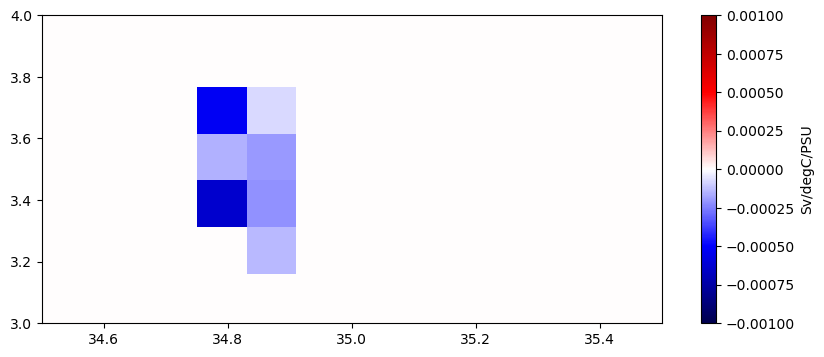

In [12]:
# plot this as a convergence
fig = plt.figure()

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,TS_density,cmap='seismic',vmin=-.001,vmax=.001)
ax.set_xlim(34.5,35.5)
ax.set_ylim(3,4)
plt.colorbar(cb,label='Sv/degC/PSU')

In [13]:
#############################################################################
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s
#print(np.nansum(SALTDR),dt)

tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
#print(np.nansum(mk3D_mod(RAC,SALTDR)))
#print(np.nansum((SALTDR - AB_gS)))
#print( myparms['rhoconst'])
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)


# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))


# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this


print("doing JtermsS")
# initialize the J vectors for salt
JtermsS = np.zeros((5,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for i,j in zip(y1d,x1d):

    # loop through the depths and add
    for k in range (0,nz):
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/degC
        JADVS = (bS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC
        JDFS = (cS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/degC
        JKPPS = (dS[k,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/degC

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,i,j] - fS[k+1,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # Sv/degC
        else:
            JsurfS = -(fS[k,i,j] - fS[k-1,i,j]) / myparms['rhoconst'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6  # Sv/degC

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

# we will not print all terms here -- overkill
print("total residual",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]),"Sv/degC")

doing salt budget
doing JtermsS
total residual -1.9336323454248106e-12 Sv/degC


In [14]:
#############################################################################
print("doing heat budget")
# create the heat budget
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
# UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
# VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s

# reshape the UVELMASS and VVELMASS to look at these
# UVELMASS = UVELMASS.reshape(nz,ny,nx)
# VVELMASS = VVELMASS.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv   # hconv + zconv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this


##########################################################
print("doing JtermsT")
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for i,j in zip(y1d,x1d):

    # loop through the z values and see if we can plot
    for k in range(0,nz-1):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JtendT = (aT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/PSU
        JADVT = (bT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU
        JDFT = (cT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/PSU
        JKPPT = (dT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU

        if k == 0:
            JsurfT = (eT[k,i,j] - fT[k+1,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU
        else:
            JsurfT = -(fT[k+1,i,j] - fT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv/PSU")

doing heat budget
2
doing JtermsT
total residual -1.4466190086646381e-13 Sv/PSU


In [15]:
# --- Build TS-binned salt "gate" term in Sv/(°C·PSU) ---
# HEREEEEE
# do the reshaping
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
ADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

# Accumulator for gates (same shape as one JtermsS slice)
J_gateS = np.zeros((nS, nT), dtype=float)  # Sv/(°C·PSU)

def add_gate_TS_density(col_SLT, bT_col, bS_col, sign_into_box):
    """
    col_SLT   : (nz,) salt 'substance' transport at the gate column [from ADVx_SLT or ADVy_SLT]
                NOTE: in your workflow you convert to g/s by multiplying with rhoconst.
    bT_col    : (nz,) T-bin indices for that gate column (can be NaN)
    bS_col    : (nz,) S-bin indices for that gate column (can be NaN)
    sign_into_box : +1 if flux is INTO the boxed region, -1 if OUT OF it
    """
    for k in range(len(bT_col)):
        iT = bT_col[k]
        iS = bS_col[k]
        if not np.isfinite(iT) or not np.isfinite(iS): 
            continue
        iT = int(iT); iS = int(iS)
        if not (0 <= iT < nT and 0 <= iS < nS):
            continue

        # Convert to PSU·m^3/s by dividing g/s by rhoconst; then to Sv/(°C·PSU)
        # IMPORTANT: use LOCAL ΔT and ΔS, not a constant.
        val_Sv_per_TS = ( sign_into_box
                          * (col_SLT[k] * myparms['rhoconst'])   # g/s if ADVx_SLT is in PSU·m^3/s; keep this line to mirror your other terms
                          / myparms['rhoconst']                   # -> PSU·m^3/s
                          / (binwidthT[iT] / binwidthS[iS])       # -> m^3/s / (°C)
                          * 1e-6 )                                # -> Sv / (°C)

        J_gateS[iS, iT] += val_Sv_per_TS

# ---- WEST/LEFT boundary (use ADVx_SLT at (j,i); choose sign so INTO box = +)
for j, i in zip(lefty, leftx):
    add_gate_TS_density(ADVx_SLT[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i],
                        sign_into_box=+1)

# ---- SOUTH/BOTTOM boundary (use ADVy_SLT at (j,i))
for j, i in zip(boty, botx):
    add_gate_TS_density(ADVy_SLT[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i],
                        sign_into_box=+1)

# ---- EAST/RIGHT boundary (flip sign relative to WEST)
for j, i in zip(righty, rightx):
    # if your stencil samples interior at i-1 for the right face, keep that here:
    add_gate_TS_density(ADVx_SLT[:, j, i-1], binned_theta[:, j, i-1], binned_salinity[:, j, i-1],
                        sign_into_box=-1)

# ---- NORTH/TOP boundary (flip sign relative to SOUTH)
for j, i in zip(topy, topx):
    add_gate_TS_density(ADVy_SLT[:, j-1, i], binned_theta[:, j-1, i], binned_salinity[:, j-1, i],
                        sign_into_box=-1)


In [16]:
# --- Build TS-binned temperature "gate" term in Sv/°C (divide by ΔT only) ---

# Accumulator (same shape as one JtermsT slice)
J_gateT = np.zeros((nS, nT), dtype=float)  # Sv/°C

def add_gate_T_density(col_TH, bT_col, bS_col, sign_into_box):
    """
    col_TH        : (nz,) temperature 'substance' transport at the gate (ADVx_TH or ADVy_TH), units K·m^3/s
    bT_col, bS_col: (nz,) bin indices for the column (NaN allowed)
    sign_into_box : +1 if flux is INTO the box, -1 if OUT OF the box
    """
    for k in range(len(bT_col)):
        iT = bT_col[k]
        iS = bS_col[k]
        if not np.isfinite(iT) or not np.isfinite(iS): 
            continue
        iT = int(iT); iS = int(iS)
        if not (0 <= iT < nT and 0 <= iS < nS):
            continue

        # Convert to PSU·m^3/s by dividing g/s by rhoconst; then to Sv/(°C·PSU)
        # IMPORTANT: use LOCAL ΔT and ΔS, not a constant.
        val_Sv_per_TS = ( sign_into_box
                          * (bT_col[k] * myparms['rcp'])   # g/s if ADVx_SLT is in PSU·m^3/s; keep this line to mirror your other terms
                          / myparms['rcp']                   # -> degC·m^3/s
                          / (binwidthS[iS] / binwidthT[iT])                   # -> m^3/s / (PSU)
                          * 1e-6 )                                # -> Sv / (PSU)

        J_gateT[iS, iT] += val_Sv_per_TS

# ---- WEST/LEFT boundary (choose sign so INTO box = +)
for j, i in zip(lefty, leftx):
    add_gate_T_density(ADVx_TH[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i], +1)

# ---- SOUTH/BOTTOM boundary
for j, i in zip(boty, botx):
    add_gate_T_density(ADVy_TH[:, j, i], binned_theta[:, j, i], binned_salinity[:, j, i], +1)

# ---- EAST/RIGHT boundary (flip sign; sample i-1 if that matches your face convention)
for j, i in zip(righty, rightx):
    add_gate_T_density(ADVx_TH[:, j, i-1], binned_theta[:, j, i-1], binned_salinity[:, j, i-1], -1)

# ---- NORTH/TOP boundary (flip sign; sample j-1 if that matches your face convention)
for j, i in zip(topy, topx):
    add_gate_T_density(ADVy_TH[:, j-1, i], binned_theta[:, j-1, i], binned_salinity[:, j-1, i], -1)


In [17]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow

ETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

# 2) Cellwise volume tendency from free surface (m^3/s)
#    ETAN is sea-surface height; multiplying by cell area RAC gives volume rate per cell.
dVdt_cell = ETAN_dt * RAC                          # m/s * m^2 = m^3/s

# If you're using virtual freshwater (useRFWF==0), there is no real mass/volume flux.
# In that case, you can zero out the real-volume tendency if desired:
if myparms.get('useRFWF', 0) == 0:
    dVdt_cell[...] = 0.0

# 3) Regional total (Sv)
dVdt_total_Sv = np.nansum(dVdt_cell) * 1e-6        # Sv
print(f"Total dV/dt = {dVdt_total_Sv:.6f} Sv")

# --------------------------------------------------------------------

tmptend = np.zeros((nz, ny, nx))                   # m^3/s per layer (optional)
if myparms.get('rStar', 0) != 0 and myparms.get('useNLFS', 0) >= 2:
    # Example: vertical weights that sum to 1 where ocean is present
    # (choose weights appropriate for your r* config; here we use thickness fractions)
    DRF3 = mk3D_mod(mygrid['DRF'], np.zeros((nz,ny,nx)))     # broadcast DRF to (nz,ny,nx)
    hC   = mygrid['hFacC']                                   # (nz,ny,nx)
    wet  = np.where(hC > 0, 1.0, 0.0)
    layer_thick = DRF3 * hC                                  # effective layer thickness
    colsum = np.nansum(layer_thick, axis=0)                  # (ny,nx)

    # Avoid divide-by-zero on land
    weights = np.where(colsum[np.newaxis,:,:] > 0, layer_thick / colsum[np.newaxis,:,:], 0.0)

    # Distribute surface volume tendency down the column
    tmptend = weights * dVdt_cell[np.newaxis, :, :]          # still m^3/s per layer
else:
    # If not using r*, keep all volume change at the surface layer (k=0)
    tmptend[0, :, :] = dVdt_cell

bT = np.asarray(binned_theta); bS = np.asarray(binned_salinity)
bwT = np.asarray(binwidthT);  bwS = np.asarray(binwidthS)
Tcent = np.asarray(binsTH_centers); Scent = np.asarray(binsSLT_centers)
xs = np.asarray(xs); ys = np.asarray(ys)

nz, ny, nx = tmptend.shape
nS = bwS.size; nT = bwT.size

# Accumulate per-bin *transport* (Sv) over depths and selected columns
TS_sum_Sv = np.zeros((nS, nT), dtype=float)

for j, i in zip(y1d, x1d):
    if not (0 <= j < ny and 0 <= i < nx):
        continue
    for k in range(nz):
        iT = bT[k, j, i]
        iS = bS[k, j, i]
        if not np.isfinite(iT) or not np.isfinite(iS):
            continue
        iT = int(iT); iS = int(iS)
        if 0 <= iT < nT and 0 <= iS < nS:
            TS_sum_Sv[iS, iT] += tmptend[k, j, i] * 1e-6  # m^3/s -> Sv

# Convert to density: Sv/(°C·PSU) by dividing by ΔT·ΔS per bin
dT = bwT[np.newaxis, :]           # (1, nT)
dS = bwS[:, np.newaxis]           # (nS, 1)
TS_density = np.divide(TS_sum_Sv, dT * dS,
                       out=np.zeros_like(TS_sum_Sv),
                       where=(dT*dS) != 0)

Total dV/dt = -1.281995 Sv


In [18]:
# 1) Transformations only (exclude internal ADV)
J_T_trans = JtermsT[2] + JtermsT[3] + JtermsT[4]   # Sv/PSU
J_S_trans = JtermsS[2] + JtermsS[3] + JtermsS[4]   # Sv/degC

# 2) Divergence helper (left/bottom = inflow)
def div_T(JT):  # Sv/°C -> Sv
    left = np.zeros_like(JT); left[:,1:] = JT[:,:-1]
    return JT - left

def div_S(JS):  # Sv/PSU -> Sv
    bot = np.zeros_like(JS); bot[1:,:] = JS[:-1,:]
    return JS - bot

# 3) Internal transformation divergence (Sv)
div_trans = div_T(J_T_trans) + div_S(J_S_trans)

# 4) Gate divergence (Sv)
div_gate = div_T(J_gateT) + div_S(J_gateS)

# 5) Binwise budget residual (Sv): expect ~ 0
res_TS = TS_sum_Sv - div_trans - div_gate

print("TS budget check (global):",
      np.nansum(TS_sum_Sv), np.nansum(div_trans), np.nansum(div_gate),
      "res =", np.nansum(res_TS))



TS budget check (global): -2.3765856800711106e-05 -1.1102230246251565e-16 -1.1102230246251565e-16 res = -2.376585680108345e-05


In [19]:
binwidthTtile = np.tile(binwidthT[np.newaxis,:],(nT,1))
binwidthStile = np.tile(binwidthS[:,np.newaxis],(1,nS))


(3.0, 5.0)

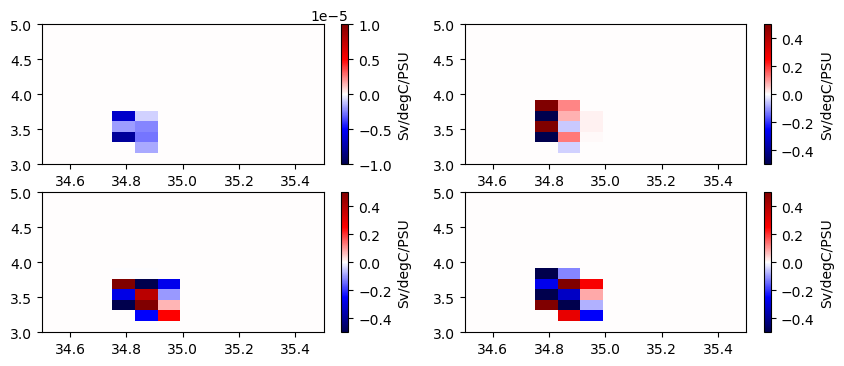

In [20]:
fig = plt.figure()
vlev=.5

ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin,Tbin,TS_sum_Sv ,vmin=-.00001,vmax=.00001,cmap='seismic')
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(34.5,35.5)
ax.set_ylim(3,5)

ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin,Tbin,div_trans,cmap='seismic',vmin=-vlev,vmax=vlev)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(34.5,35.5)
ax.set_ylim(3,5)

ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin,Tbin,div_gate,cmap='seismic',vmin=-vlev,vmax=vlev)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(34.5,35.5)
ax.set_ylim(3,5)


ax = plt.subplot(224)
cb = ax.pcolormesh(Sbin,Tbin,res_TS,cmap='seismic',vmin=-vlev,vmax=vlev)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(34.5,35.5)
ax.set_ylim(3,5)